# Predicting Hanoi, Vietnam housing price

In [2]:
import warnings
import os
import numpy as np
import pandas as pd
import datetime 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor

## 1. Importing libraries, cleaning data, and removing outliers

In [3]:
# Ignoring future warnings and deprecation warnings so as not to make the notebook full of warnings
warnings.filterwarnings("ignore")

In [4]:
# Reading the first few lines of the dataset
df = pd.read_csv("./data.csv")
df.head() 

,Unnamed: 0,Ngày,Địa chỉ,Quận,Huyện,Loại hình nhà ở,Giấy tờ pháp lý,Số tầng,Số phòng ngủ,Diện tích,Dài,Rộng,Giá/m2
0,0.0,2020-08-05,"Đường Hoàng Quốc Việt, Phường Nghĩa Đô, Quận C...",Quận Cầu Giấy,Phường Nghĩa Đô,"Nhà ngõ, hẻm",Đã có sổ,4,5 phòng,46 m²,NaN,NaN,"86,96 triệu/m²"
1,1.0,2020-08-05,"Đường Kim Giang, Phường Kim Giang, Quận Thanh ...",Quận Thanh Xuân,Phường Kim Giang,"Nhà mặt phố, mặt tiền",NaN,NaN,3 phòng,37 m²,NaN,NaN,"116,22 triệu/m²"
2,2.0,2020-08-05,"phố minh khai, Phường Minh Khai, Quận Hai Bà T...",Quận Hai Bà Trưng,Phường Minh Khai,"Nhà ngõ, hẻm",Đã có sổ,4,4 phòng,40 m²,10 m,4 m,65 triệu/m²
3,3.0,2020-08-05,"Đường Võng Thị, Phường Thụy Khuê, Quận Tây Hồ,...",Quận Tây Hồ,Phường Thụy Khuê,"Nhà ngõ, hẻm",Đã có sổ,NaN,6 phòng,51 m²,12.75 m,4 m,100 triệu/m²
4,4.0,2020-08-05,"Đường Kim Giang, Phường Kim Giang, Quận Thanh ...",Quận Thanh Xuân,Phường Kim Giang,"Nhà ngõ, hẻm",NaN,NaN,4 phòng,36 m²,9 m,4 m,"86,11 triệu/m²"


In [5]:
# The length of the dataset before cleaning and removing outliers
print("The initial length of the dataset is", str(len(df)), "rows.")

The initial length of the dataset is 82497 rows.


### Cleaning data and removing outliers

Renaming/Translating column names

In [6]:
df_renamed = df.rename(columns = {"Ngày":"date", "Địa chỉ":"address", "Quận":"district", 
                                  "Huyện":"ward", "Loại hình nhà ở":"type_of_housing",
                                 "Giấy tờ pháp lý":"legal_paper", "Số tầng":"num_floors",
                                 "Số phòng ngủ":"num_bed_rooms", "Diện tích":"squared_meter_area",
                                 "Dài":"length_meter", "Rộng":"width_meter", "Giá/m2":"price_in_million_per_square_meter"})
df_renamed = df_renamed.drop("Unnamed: 0", axis = 1)
df_renamed = df_renamed.dropna()
df_renamed = df_renamed.reset_index()

# The length of the dataset after dropping null values
print("The length of the dataset after dropping null values is", str(len(df_renamed)), "rows.")

The length of the dataset after dropping null values is 11473 rows.


Cleaning data within each columns

In [7]:
# Remove houses with "10 plus" floors and bed rooms, since this cannot be exactly quantified
df_renamed = df_renamed[df_renamed['num_floors'] != 'Nhiều hơn 10']
df_renamed = df_renamed[df_renamed['num_bed_rooms'] != 'nhiều hơn 10 phòng']

# Clean columns and convert numerical columns to float type
df_renamed['district'] = df_renamed['district'].str.replace('Quận ','').str.strip()
df_renamed['ward'] = df_renamed['ward'].str.replace('Phường ','').str.strip()
df_renamed['num_floors'] = df_renamed['num_floors'].str.strip().astype(float)
df_renamed['num_bed_rooms'] = df_renamed['num_bed_rooms'].str.replace(' phòng','').str.strip().astype(float)
df_renamed['squared_meter_area'] = df_renamed['squared_meter_area'].str.replace(' m²','').str.strip().astype(float)
df_renamed['length_meter'] = df_renamed['length_meter'].str.replace(' m','').str.strip().astype(float)
df_renamed['width_meter'] = df_renamed['width_meter'].str.replace(' m','').str.strip().astype(float)

# Clean and convert all prices to million/m2 instead of VND/m2 or billion/m2
df_renamed.loc[df_renamed['price_in_million_per_square_meter'].str.contains(' tỷ/m²'), 'price_in_million_per_square_meter'] = df_renamed.loc[df_renamed['price_in_million_per_square_meter'].str.contains(' tỷ/m²'), 'price_in_million_per_square_meter'].str.replace(' tỷ/m²','').str.replace('.','').str.replace(',','.').astype(float) * 1000
df_renamed.loc[df_renamed['price_in_million_per_square_meter'].str.contains(' triệu/m²', na=False), 'price_in_million_per_square_meter'] = df_renamed.loc[df_renamed['price_in_million_per_square_meter'].str.contains(' triệu/m²', na=False), 'price_in_million_per_square_meter'].str.replace(' triệu/m²','').str.replace(',','.').astype(float)
df_renamed.loc[df_renamed['price_in_million_per_square_meter'].str.contains(' đ/m²', na=False), 'price_in_million_per_square_meter'] = df_renamed.loc[df_renamed['price_in_million_per_square_meter'].str.contains(' đ/m²', na=False), 'price_in_million_per_square_meter'].str.replace(' đ/m²','').str.replace('.','').astype(float) * 0.000001

In [8]:
# Create dummies for categorical columns
dummy_type_of_housing = pd.get_dummies(df_renamed.type_of_housing, prefix="housing_type")
dummy_legal_paper = pd.get_dummies(df_renamed.legal_paper, prefix="legal_paper")
dummy_district = pd.get_dummies(df_renamed.district, prefix="district")
dummy_ward = pd.get_dummies(df_renamed.ward, prefix="ward")

df_cleaned = pd.concat([df_renamed, dummy_type_of_housing, dummy_legal_paper, dummy_district, dummy_ward], axis=1)
df_cleaned = df_cleaned.drop(['index', 'date', 'address', 'district', 'ward', 'type_of_housing', 'legal_paper'], axis = 1)
df_cleaned.head()

,num_floors,num_bed_rooms,squared_meter_area,length_meter,width_meter,price_in_million_per_square_meter,housing_type_Nhà biệt thự,"housing_type_Nhà mặt phố, mặt tiền","housing_type_Nhà ngõ, hẻm",housing_type_Nhà phố liền kề,...,ward_Đại Mỗ,ward_Định Công,ward_Đống Mác,ward_Đồng Mai,ward_Đồng Nhân,ward_Đồng Tâm,ward_Đồng Xuân,ward_Đội Cấn,ward_Đức Giang,ward_Đức Thắng
0,4.0,4.0,40.0,10.0,4.0,65.0,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,5.0,4.0,52.0,12.0,4.2,93.27,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,5.0,5.0,90.0,18.0,5.0,108.89,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,4.0,3.0,32.0,6.6,4.5,60.94,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,3.0,2.0,42.0,11.0,4.0,29.76,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


Removing outliers using IQR method

In [9]:
def remove_outlier_IQR(df, series):
    Q1=df[series].quantile(0.25)
    Q3=df[series].quantile(0.75)
    IQR=Q3-Q1
    df_final=df[~((df[series]<(Q1-1.5*IQR)) | (df[series]>(Q3+1.5*IQR)))]
    return df_final

removed_outliers = df_cleaned
columns_to_remove_outliers = ['num_floors', 'num_bed_rooms', 'squared_meter_area', 'length_meter',
                              'width_meter', 'price_in_million_per_square_meter']
for column in columns_to_remove_outliers:
    removed_outliers = remove_outlier_IQR(removed_outliers, column)
    
print("The final length of the dataset is", str(len(removed_outliers)), "rows.")

The final length of the dataset is 7328 rows.


## 2. Training a Artificial Neural Network (ANN) for Regression

Scale variables using Standard Scaler and create train-test set

In [26]:
housing = removed_outliers

# Separate predictors and response (price) variables
X = housing.loc[:, housing.columns != 'price_in_million_per_square_meter']
y = housing[['price_in_million_per_square_meter']]
to_be_scaled = ['num_floors', 'num_bed_rooms', 'squared_meter_area', 'length_meter', 'width_meter']

# Initiate scaler
PredictorScaler=StandardScaler()
TargetVarScaler=StandardScaler()

X_scaled = X
y_scaled = y

# Storing the fit object for reference and reverse the scaling later
PredictorScalerFit=PredictorScaler.fit(X_scaled[to_be_scaled])
TargetVarScalerFit=TargetVarScaler.fit(y_scaled)
 
# Generating the standardized values of X and y
X_scaled[to_be_scaled]=PredictorScalerFit.transform(X_scaled[to_be_scaled])
y_scaled=TargetVarScalerFit.transform(y)

X_array = np.array(X_scaled.values).astype("float32")
y_array = np.array(y_scaled).astype("float32")

X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, test_size=0.2, random_state=2032)

# Sanity check to see if all train and test arrays have correct dimensions
if X_train.shape[0] == y_train.shape[0] and X_train.shape[1] == X_test.shape[1] and X_test.shape[0] == y_test.shape[0] and y_train.shape[1] == y_test.shape[1]:
    print("All train and test sets have correct dimensions.")

All train and test sets have correct dimensions.


In [27]:
# Fitting the ANN to the Training set
ANN = Sequential()                
ANN.add(Dense(units=10, input_dim=X_train.shape[1], 
                kernel_initializer='normal', activation='relu'))
ANN.add(Dense(1, kernel_initializer='normal'))
ANN.compile(loss='mean_squared_error', optimizer='adam')
ANN.fit(X_train, y_train,batch_size = 30,
        epochs = 10, verbose=0)

# Generating Predictions on testing data
ANN_predictions = ANN.predict(X_test)
 
# Scaling the predicted Price data back to original price scale
ANN_predictions = TargetVarScalerFit.inverse_transform(ANN_predictions)
 
# Scaling the y_test Price data back to original price scale
y_test_orig = TargetVarScalerFit.inverse_transform(y_test)
 
# Scaling the test data back to original scale
Test_Data = np.concatenate((PredictorScalerFit.inverse_transform(X_test[:,:5]), X_test[:,5:]), axis=1)

# Recreating the dataset, now with predicted price using the ANN model
TestingData = pd.DataFrame(data=Test_Data, columns=X.columns)
TestingData['Price'] = y_test_orig
TestingData['ANN_predictions'] = ANN_predictions

TestingData[['Price', 'ANN_predictions']].head()

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step


,Price,ANN_predictions
0,77.139999,72.960419
1,121.949997,112.423912
2,66.669998,74.767761
3,80.559998,111.570969
4,133.330002,109.445969


#### Finding best parameters for the ANN using grid search

In [28]:
# Turn off TensorFlow messages and warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["KMP_SETTINGS"] = "false"

# Create the base model
def create_regression_ANN(optimizer_trial='adam'):
    model = Sequential()
    model.add(Dense(units=10, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer=optimizer_trial)
    return model

# Creathe a dictionary for trial parameters
ANN_params = {'batch_size':[10, 20, 30, 50],
             'epochs':[10, 20, 50],
             'model__optimizer_trial':['adam', 'rmsprop']}

ANN_trial = KerasRegressor(model=create_regression_ANN, verbose=0)

# Initiate the grid search and storing best parameters for later reference
ANN_grid_search = GridSearchCV(estimator=ANN_trial, param_grid=ANN_params, 
                               cv=3, n_jobs = -1).fit(X_train, y_train, verbose=0)
ANN_best_params = ANN_grid_search.best_params_

# Showing the best parameters
ANN_best_params

KeyboardInterrupt: 

#### Training the ANN model with the best parameters

In [ ]:
# Fitting the ANN to the Training set
ANN = Sequential()                
ANN.add(Dense(units=10, input_dim=X_train.shape[1], 
                kernel_initializer='normal', activation='relu'))
ANN.add(Dense(1, kernel_initializer='normal'))
ANN.compile(loss='mean_squared_error', optimizer=ANN_best_params['model__optimizer_trial'])
ANN.fit(X_train, y_train,batch_size = int(ANN_best_params['batch_size']),
        epochs = int(ANN_best_params['epochs']), verbose=0)

# Generating Predictions on testing data
ANN_predictions = ANN.predict(X_test)
 
# Scaling the predicted Price data back to original price scale
ANN_predictions = TargetVarScalerFit.inverse_transform(ANN_predictions)
 
# Scaling the y_test Price data back to original price scale
y_test_orig = TargetVarScalerFit.inverse_transform(y_test)
 
# Scaling the test data back to original scale
Test_Data = np.concatenate((PredictorScalerFit.inverse_transform(X_test[:,:5]), X_test[:,5:]), axis=1)

# Recreating the dataset, now with predicted price using the ANN model
TestingData = pd.DataFrame(data=Test_Data, columns=X.columns)
TestingData['Price'] = y_test_orig
TestingData['ANN_predictions'] = ANN_predictions

TestingData[['Price', 'ANN_predictions']].head()

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step


,Price,ANN_predictions
0,77.139999,72.978294
1,121.949997,111.686882
2,66.669998,68.060524
3,80.559998,99.184715
4,133.330002,110.488068


## 3. Training a Random Forest model for Regression

#### Finding best parameters for the Random Forest model using random search and grid search

In [18]:
# Create a dictionary of random parameters for the model
RF_random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)],
               'max_features': ['auto', 'sqrt', 'log2'],
               'max_depth': [int(x) for x in np.linspace(10, 100, num = 10)],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

In [19]:
# Turn off TensorFlow messages and warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["KMP_SETTINGS"] = "false"

# Create the base RF model and fit the random search
RF_regressor = RandomForestRegressor()
RF_random_search = RandomizedSearchCV(estimator=RF_regressor, param_distributions=RF_random_grid, n_iter=100, cv=5, 
                                      verbose=0, random_state=2022, n_jobs = -1).fit(X_train, np.ravel(y_train))
RF_best_params = RF_random_search.best_params_
RF_best_params

{'n_estimators': 900,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 40,
 'bootstrap': True}

In [20]:
# Narrowing the parameters grid based on the best parameters given by the random search, then feed the grid to a grid search
RF_param_grid = {'n_estimators': [RF_best_params['n_estimators']-100, RF_best_params['n_estimators'], RF_best_params['n_estimators']+100],
               'max_features': ['sqrt', 'log2'],
               'max_depth': [RF_best_params['max_depth'] - 10, RF_best_params['max_depth'], RF_best_params['max_depth']+10],
               'min_samples_split': [5, 10],
               'min_samples_leaf': [1, 2],
               'bootstrap': [True, False]}

In [21]:
# Turn off TensorFlow messages and warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["KMP_SETTINGS"] = "false"

# Create another base RF model and fit the grid search
RF_regressor_2 = RandomForestRegressor()
RF_grid_search = GridSearchCV(estimator=RF_regressor_2, param_grid=RF_param_grid, 
                              cv=3, n_jobs=-1, verbose=0).fit(X_train, np.ravel(y_train))

# Showing the best parameters
RF_grid_search.best_params_

{'bootstrap': False,
 'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 1000}

#### Training the RF model with the best parameters

In [23]:
# Fitting a RF model with the best parameters
RF = RF_grid_search.best_estimator_

# Generating Predictions on testing data
RF_predictions = RF.predict(X_test)

# Reshaping the predictions to 2D for inverse transform
RF_predictions_reshaped = RF_predictions.reshape(-1, 1)

# Scaling the predicted Price data back to original price scale
RF_predictions_original_scale = TargetVarScalerFit.inverse_transform(RF_predictions_reshaped)

# Add predictions back to TestingData
TestingData['RF_predictions'] = RF_predictions_original_scale.flatten()

# Display the results
print(TestingData[['Price', 'ANN_predictions', 'RF_predictions']].head())


        Price  ANN_predictions  RF_predictions
0   77.139999        72.978294       74.114400
1  121.949997       111.686882      119.624212
2   66.669998        68.060524       74.996549
3   80.559998        99.184715       90.608603
4  133.330002       110.488068      111.855920


## 4. Training a KNN model

In [30]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

knn = KNeighborsRegressor(n_neighbors=5)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 0.66397464


#### Training the KNN model with the best parameters

In [31]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2] 
}

grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_k = grid_search.best_params_['n_neighbors']
print("Optimal number of neighbors:", best_k)

knn_optimized = KNeighborsRegressor(n_neighbors=best_k)
knn_optimized.fit(X_train, y_train)
y_pred_optimized = knn_optimized.predict(X_test)

mse_optimized = mean_squared_error(y_test, y_pred_optimized)
print("Optimized Mean Squared Error:", mse_optimized)

Optimal number of neighbors: 15
Optimized Mean Squared Error: 0.61680686


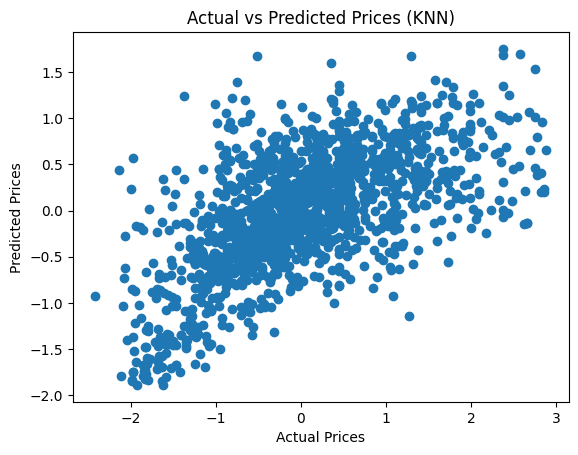

In [32]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred_optimized)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices (KNN)")
plt.show()

## Final result: Artifical Neural Network vs. Random Forest

In [24]:
# Define a function evaluate the predictions
def Accuracy_Score(orig, pred):
    MAPE = np.mean(100 * (np.abs(orig - pred) / orig))
    return(100-MAPE)

In [25]:
# Showing scores for both the ANN and the RF model
print("Accuracy for the ANN model is:", str(Accuracy_Score(TestingData['Price'], TestingData['ANN_predictions'])))
print("Accuracy for the RF model is:", str(Accuracy_Score(TestingData['Price'], TestingData['RF_predictions'])))

Accuracy for the ANN model is: 83.380844
Accuracy for the RF model is: 83.00205504441773
